Setup

In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
%run ConV_VAE.ipynb
%run loader.ipynb
%run test.ipynb
%run train.ipynb

In [9]:
plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
####### IMPORTANT ######
# set this flag to true if you want to load the model beforehand
load = False
# specify which model you want to load
model_name = None

Additional Setup to use Tensorboard<br>
!pip install -q tensorflow<br>
%load_ext tensorboard

In [10]:
normalize = transforms.Normalize(160, 50)
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
train_data = CustomImageDataset('../Data/sign_mnist_train.csv', transform=transform)
test_data = CustomImageDataset('../Data/sign_mnist_test.csv')
# mnist_data = datasets.MNIST('./data',
#              transform=transforms.ToTensor(),
#             download=True)

Put it into a dataloader for easier handling in pytorch

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [12]:
model = ConvVarAutoencoder().to(device)
if (load):
    model.load_state_dict(torch.load(model_name, map_location=device))

criterion = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)

In [ ]:
epochs = 10
train_losses = []
test_losses = []
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train_vae(train_loader, model, optimizer, device)
    test_loss = test(epoch, model, test_loader)
    print('====> Training loss: {train} KL Divergence {kl}'.format(train=train_loss.item(),kl=model.encoder.kl.item()))
    print('====> Test set loss: {:.4f}'.format(test_loss))
    # Write metrics to Tensorboard
    #writer.add_scalars("Loss", {'Train': train_loss}, epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), "../model/model" + str(epoch) + ".pt")
        with torch.no_grad():
            sample = torch.randn(64, 2048).to(device)
            sample = model.decoder(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../results/' + str(epoch) + '.png')
    train_losses.append(train_loss.cpu().detach().numpy())
    test_losses.append(test_loss)

 10%|█         | 1/10 [00:16<02:30, 16.67s/it]

====> Training loss: 134863.546875 KL Divergence 4266043.5
====> Test set loss: 857000724.3860


 20%|██        | 2/10 [00:32<02:11, 16.41s/it]

====> Training loss: 124084.578125 KL Divergence 4495441.5
====> Test set loss: 668962433.7544


 30%|███       | 3/10 [00:50<01:58, 16.94s/it]

====> Training loss: 122071.6015625 KL Divergence 5045387.0
====> Test set loss: 515123997.2632


 40%|████      | 4/10 [01:08<01:44, 17.41s/it]

====> Training loss: 120768.5546875 KL Divergence 4595072.0
====> Test set loss: 493955720.6316


 50%|█████     | 5/10 [01:25<01:26, 17.36s/it]

====> Training loss: 119845.578125 KL Divergence 6910696.0
====> Test set loss: 416893201.7544


 60%|██████    | 6/10 [01:43<01:09, 17.29s/it]

====> Training loss: 118948.5078125 KL Divergence 4568061.0
====> Test set loss: 449397276.3333


 70%|███████   | 7/10 [02:00<00:52, 17.51s/it]

====> Training loss: 118224.890625 KL Divergence 131151784.0
====> Test set loss: 443246161920.8421


 80%|████████  | 8/10 [02:20<00:36, 18.24s/it]

====> Training loss: 117635.0703125 KL Divergence 4069787.75
====> Test set loss: 526986111.1930


 90%|█████████ | 9/10 [02:38<00:18, 18.13s/it]

====> Training loss: 117254.6875 KL Divergence 6736909.0
====> Test set loss: 5375939564.6842


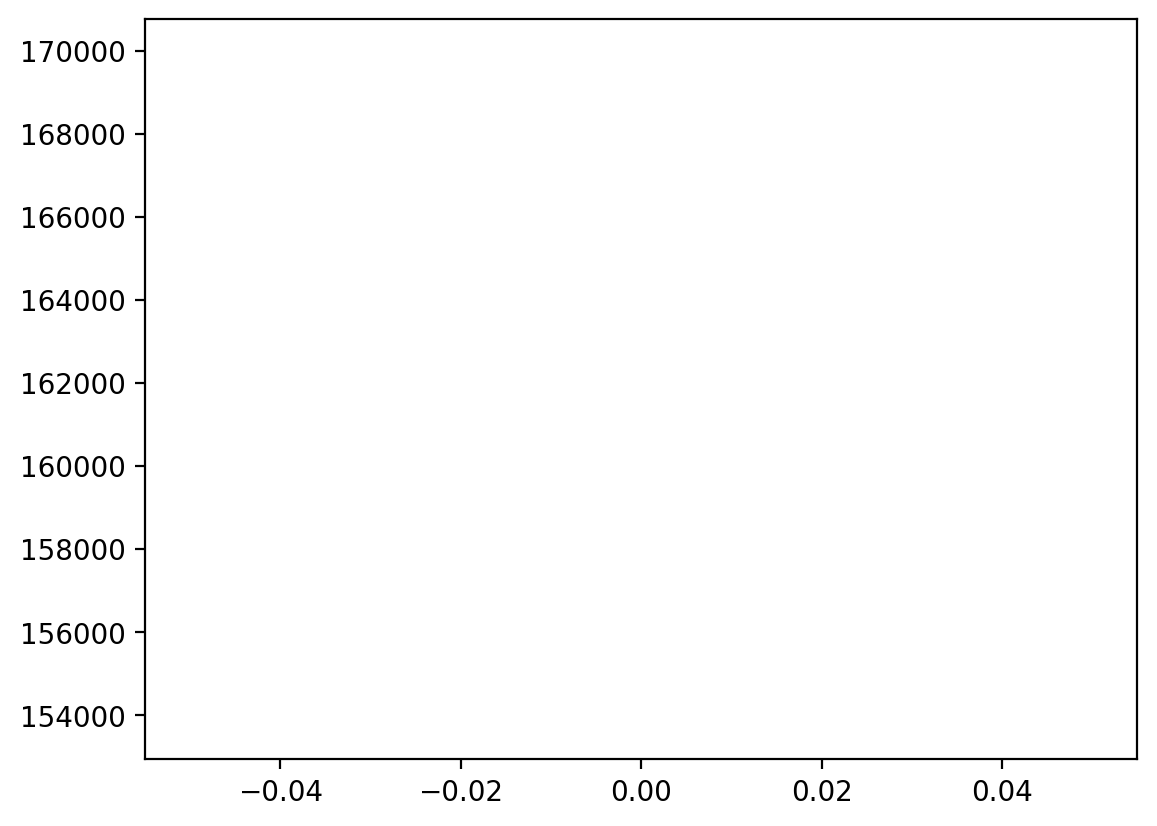

In [14]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()